<img src='../data/imgs/udesa_logo.png'>

<h1> Notebook de analisis de modelos: ResNet18

<h2> Cargamos el modelo

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision import models, transforms
from utils_dataset import get_val_dataset_and_loader
from analisis import plot_gradcam_indices, extract_features
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

<h4> Cargo el dataset con sus respectivas transformaciones

In [2]:
imagenet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_dataset, val_loader = get_val_dataset_and_loader(
    csv_file="../data/stanford_cars/labels_val.csv",
    img_dir="../data/stanford_cars/validation",
    transform=imagenet_transform,
)

<h4> Definir el modelo y cargar los pesos entrenados

In [3]:
num_classes = 49
model = models.resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, num_classes)
)
model.load_state_dict(torch.load("../pesos/resnet18_best.pth", map_location="cpu"))
model = model.to("cpu")
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h4> Evaluo el modelo en el conjunto de validación

In [4]:
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

<h2> Analisis cuantitiativo

En primer lugar queremos hacer un analisis tradicional, cualititvio para ver los resultados generales de los modelos. Para esto vamos a ver metricas generales como la accuracy, precision, recall y f1-score, y las curvas de entrenamiento, matriz de confusion, etc.

<img src='../data/imgs/resnet 18 50 e.png'>

De las curvas de entrenamiento podemos ver que el modelo converge y no hay overfitting, lo cual es bueno.

In [5]:
# Primero mostramos métricas generales para todas las etiquetas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'ResNet18': [accuracy, precision, recall, f1]
})
metrics_df['ResNet18'] = metrics_df['ResNet18'].round(2)
display(metrics_df)

,Metric,ResNet18
0,Accuracy,0.78
1,Precision,0.79
2,Recall,0.78
3,F1-score,0.78


In [6]:
# Mostramos las predicciones para todas las etiquetas
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.75      0.33      0.46         9
           1       0.91      0.80      0.85        51
           2       0.86      0.86      0.86        36
           3       0.83      0.85      0.84       117
           4       0.79      0.88      0.83       102
           5       0.86      0.93      0.89        40
           6       0.83      1.00      0.91        10
           7       0.74      0.79      0.76        33
           8       0.68      0.88      0.77        32
           9       0.71      0.83      0.77       181
          10       0.82      0.74      0.78        43
          11       1.00      0.73      0.84        11
          12       0.88      0.81      0.84       132
          13       1.00      0.62      0.77         8
          14       0.70      0.88      0.78         8
          15       0.78      0.78      0.78        37
          16       0.67      0.60      0.63        10
          17       0.69    

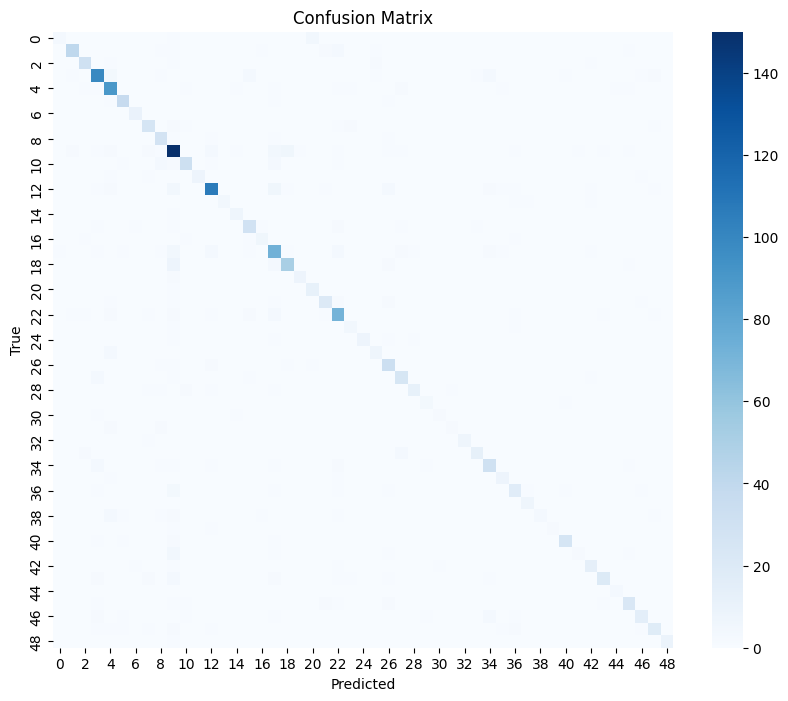

In [7]:
# Matriz de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

<h2> Analisis cualitativo de las predicciones

Esta parte es un analisi mas enfocado a como son los resultados de las preddicones en si mas alla de si estan bien o mal, sino que queremos ver como se comporta el modelo en las diferentes clases, y como se comporta en las diferentes imagenes.

En primer lugar, vamos a ver imagenes donde el modelo acierta y falla, para train y validacion, para ver si podemos tener una mejor idea de que es lo que el modelo esta aprendiendo.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


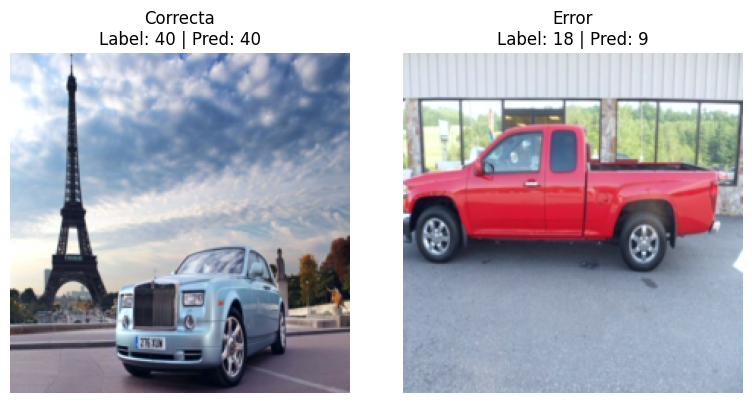

In [8]:
# Mostramos una imagen correctamente clasificada y una mal clasificada
correct_indices = [i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p == l]
incorrect_indices = [i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p != l]

idx_correct = random.choice(correct_indices)
img_correct, label_correct = val_dataset[idx_correct]
pred_correct = all_preds[idx_correct]

idx_incorrect = random.choice(incorrect_indices)
img_incorrect, label_incorrect = val_dataset[idx_incorrect]
pred_incorrect = all_preds[idx_incorrect]


fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Imagen correctamente clasificada
axs[0].imshow(img_correct.permute(1, 2, 0).numpy() * 0.229 + 0.485)  # Desnormalizar si es necesario
axs[0].set_title(f"Correcta\nLabel: {label_correct} | Pred: {pred_correct}")
axs[0].axis('off')

# Imagen mal clasificada
axs[1].imshow(img_incorrect.permute(1, 2, 0).numpy() * 0.229 + 0.485)
axs[1].set_title(f"Error\nLabel: {label_incorrect} | Pred: {pred_incorrect}")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Luego, vamos a aplicar el algoritmo de Grad-CAM para ver que regiones de la imagen son las que el modelo esta usando para hacer sus predicciones.

c:\Users\03tom\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


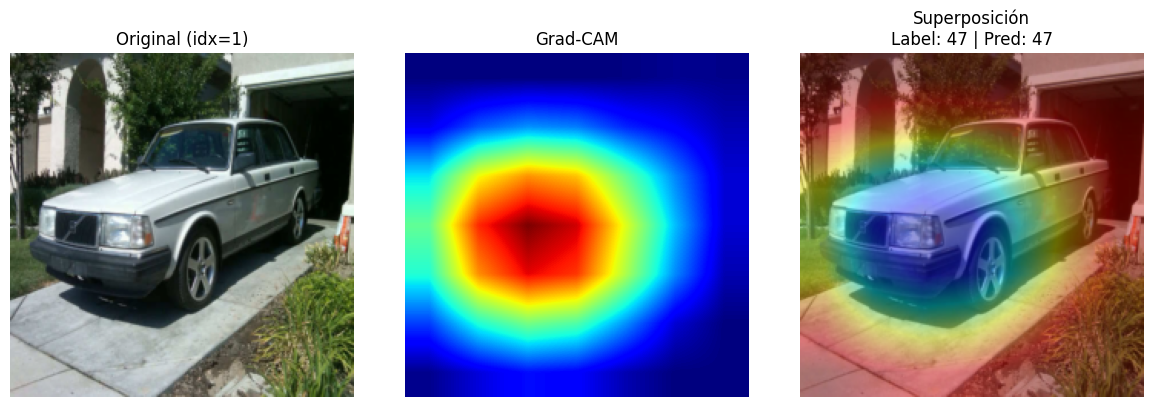

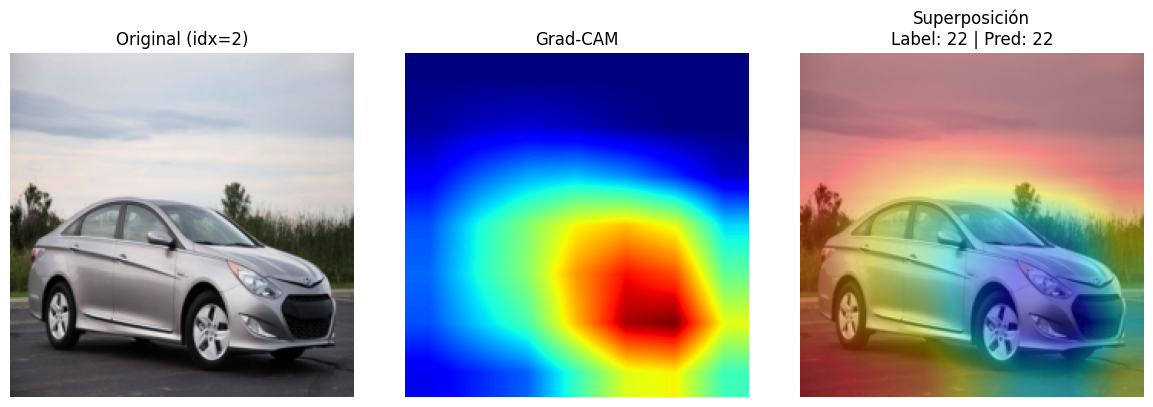

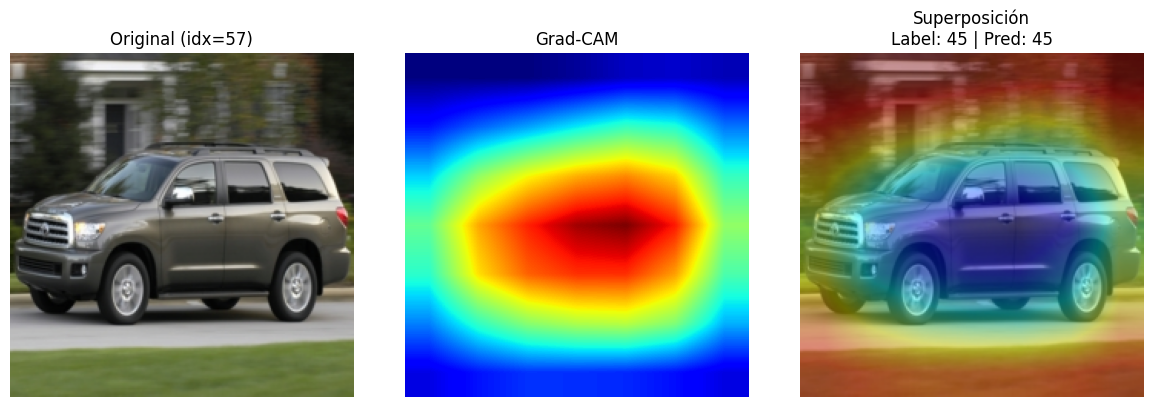

In [9]:
plot_gradcam_indices(model, val_dataset, indices=[1, 2, 57])

Por lo que podemos ver, el modelo esta capturando las regiones delanteras de los autos principalmente para poder diferenciaarlos, entonces, tal vez imagenes donde esten vistos desde atras o autos que tengan un frente parecido podrian causarle problemas al modelo.

Por utlimo, queremos ver un poco las caractersiticas que extrajo para cada clase en baja dimensionalidad, para ver como se agrupan las caracteriticas de las diferentes clases, y ver si se logran separar bien y hay clusters bien definidos, o si hay clases que se mezclan entre si.

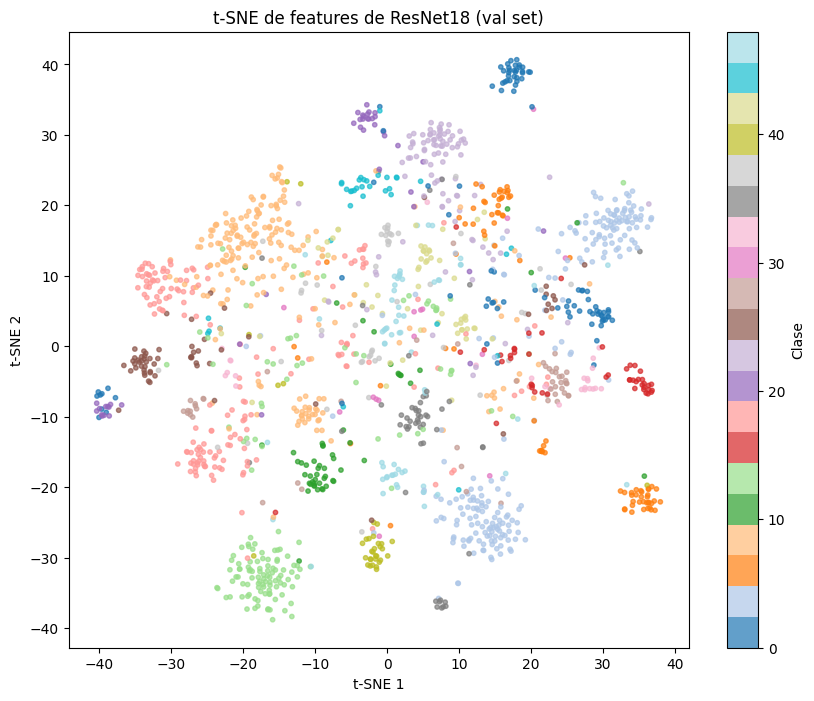

In [10]:
# Extraigo features y labels de la penultima capa (antes de clasificar)
features, labels = extract_features(model, val_loader)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features)

# Graficar
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab20', s=10, alpha=0.7)
plt.colorbar(scatter, label='Clase')
plt.title("t-SNE de features de ResNet18 (val set)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

A pesar de reducir la dimension de nuestras caracteristicas, podemos ver que el modelo logra separar las clases de manera bastante clara, hay una gran mayoria de clases que tiene caractersiticas bien separadas, pero puede ser que en el medio las clases se mezclen un poco mas.

In [11]:
np.savez("../data/pred/predicciones_resnet18.npz", preds=all_preds, labels=all_labels)